## Pre-Preliminary Version


### Sampling Methods for Class Imbalance Issues

#### Project for the Statistical Modelling Course - Felix Adam

When used properly, statistical classification can help to tackle all sorts of problems: identifiyng fraud, rare diseases or excellent products. However, problems can arise, when the class of interest is severily underrepresented in the data.

It is easy to imagine, that the number of observations of the class of interest doesn't exceed 5 percent of all observations. Linear classifiers such as logistic regression tend to perform badly in this setting, due to the fact that they 'learn' the features of the majority class. Predicting that an observation belongs to the majority class is a simple task in this case, while the minority class won't be predicted at all. 

- Example: Rare disease found in 10 / 1000 people
- Classifier just assigns healthy to every person
- Will have accuracy of 99% -> Great?

An example could be that doctors use an algorithm to classify patients as healthy or not healthy, with respect to a rare disease. The algorithm is trained on a large sample, with potentially thousands of observations. However, if the sample only contains a small amount of 'interesting' cases, the algorithm will learn the healthy cases. When used in action, this will lead to devistating results, given that all sick patients are potentially classified as healthy. 

Ironically, predicting rare events is one of the most important and interesting tasks in classification. Luckily, there are some techniques for dealing with class imbalances. This notebook is centered around the question of how to deal with such imbalances, following a real data set. 
I will first discuss the issues that arise when not accounting for class imbalances. Then I'll present undersampling of the majority class as simple remedy. I will later extend this method to synthetic oversampling using the Synthetic Minority Oversampling Technique (SMOTE). In the last section I'll discuss further applications, benefits and shortfalls of the presented techniques and other options available.

- My findings are

0. The data

1. Demonstrate the issue using the wine example
    
    - Logistic regression seemingly performs well when checking accuracy
    - Horrible performance in total, only able to classify "uninteresting classes"
    - Discussion of ROC, AUC and general assessment of classifiers
    - Aiming for high AUC!
    - -> Good general performance!
    - Provost and Fawcett (1997): Convex hull
    
2. Re-Sampling Methods with application in logistic regression
    - Crucial to reweight the learned probabilities!
    - Check also, what is the intercept?

2. Simple resampling: Undersampling of the majority class

    - Discuss method
    - Methodology, idea behind it -> Theory
    - Show performance compared to base case

3. Extension: SMOTE

    - Theory, methodology
    - Discuss
    - Implement and show performance

4. Discussion: Which method should be used?

    - What about just moving the descision boundary? (Also mentioned in the SMOTE paper)
    - Benefits/ Shortfalls
    

#### Notes

- Issue of PREDICTION 
- Aim of this doc is to present sampling methods, not classifiers
- No information rate (see book, page 255)
- CV done false: Check your CV set up
- When are you using sampling techniques? Before or after CV?
- CV at all?
- What about flipping the situation around, making the majority class the minority class? Would this make any sense?
- Check, whether there is actually a clear linear descision boundary, which could be exploited, otherwise use aritifical data!



Consider testing under-sampling when you have an a lot data (tens- or hundreds of thousands of instances or more)
Consider testing over-sampling when you don’t have a lot of data (tens of thousands of records or less)
Consider testing random and non-random (e.g. stratified) sampling schemes.

#### This is important
Consider testing different resampled ratios (e.g. you don’t have to target a 1:1 ratio in a binary classification problem, try other ratios)
        - Play around with different ratios, try to get the optimum, however, try on training set
        - Maybe also shows overfitting in the end!


In [1]:
%matplotlib inline

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

#### The Wine-Quality Data Set
To make this issue more tangible, I will use the wine-quality dataset presented by Cortez et. al (2009). The dataset contains information on red and white wines from the Minho region in Portugal. I will focus on predicting the quality of white wine in this example.

##### Data Loading 

In [38]:
# Filepath
filepath = "../data/"



# Loading data
wine = pd.read_csv(filepath+ 'winequality-white.csv', sep= ";")

#wine = pd.read_csv(filepath + 'winequality-red.csv', sep = ";")

The dataset includes {{wine.shape[0]}} observations, each with {{wine.shape[1]}} features, where one feature is the quality of the wine (see table below). The wines are assesed by three professional wine tasters who give each wine a grade from 0 (bad) to 10 (excellent). The final grade is calculated as the median of the three values (Cortez et al. 2009). While wine tasting has a bad reputation as being unscientific (Hodgson, 2008), I will assume that the scores actually represent a valid rating. At a minimum, the goal is to predict the taste of these three particular wine tasters.

In [39]:
wine.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2816,7.2,0.17,0.41,1.60,0.052,24.0,126.0,0.99228,3.19,0.49,10.8,5
631,7.0,0.23,0.42,18.05,0.050,35.0,144.0,0.99990,3.22,0.42,8.8,5
157,6.1,0.32,0.24,1.50,0.036,38.0,124.0,0.98980,3.29,0.42,12.4,7
2646,5.7,0.18,0.36,1.20,0.046,9.0,71.0,0.99199,3.70,0.68,10.9,7
3900,7.0,0.34,0.10,3.50,0.044,17.0,63.0,0.99370,3.01,0.39,9.2,5


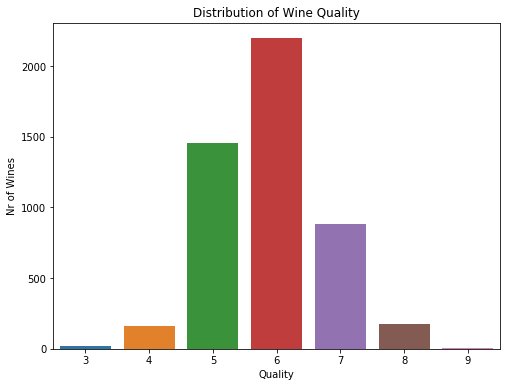

In [40]:
plt.rcParams['figure.figsize'] = (8,6)
quality_plt = sns.countplot(x= 'quality', data=wine)
quality_plt.set_xlabel('Quality')
quality_plt.set_ylabel('Nr of Wines')
quality_plt.set_title('Distribution of Wine Quality');

#### Binary Predictions
My goal is to predict the quality of a wine using its chemical features. To simplify the estimation and emphasize the issue of class imbalances, I will transform the problem to a 'One vs. Rest' setup (Bishop ,2006, p. 183f). Wines with a quality equal or above 8 will be assigned to have high quality and wines below 8 are classified as low quality.

As shown above, the quality of most wines lies between 5 and 7. Transforming the quality to binary values, one can see that high quality wines are severily underrepresented.

- Example using costs
The idea behind logistic regression can be motivated from an example. A winery has collected the grapes of the season and the winegrower has given her best to produce an excellent wine. Now the accountant of the winery comes into play and asks how he should price the wine, given it's quality. Preferrably, he would like to have an idea of how sure he can be that a wine is of particularly high quality, so that he doesn't end up with a mountain of overpriced, low quality wine. Logistic regression can be used in this case to obtain the probability of a wine belonging to the high quality group.


In [41]:
wine['quality_class'] = [1 if q >=  8 else 0 for q in wine.quality]

# Calculating base rate
base_rate = round(wine['quality_class'].value_counts()[1]/wine['quality_class'].value_counts()[0] ,4) 

In [42]:
base_rate * 100

3.82

After the transformation, there are {{wine['quality_class'].value_counts()[0]}} observations of low quality wines and {{wine['quality_class'].value_counts()[1]}} obersvations of high quality wines. The base rate in this case is 
{{ round(base_rate \* 100,2)}} percent. It is important to notice, that one could achieve a prediction accuracy of {{round((1-base_rate) * 100,2)}} percent by guessing that all wines presented belong to the low quality class.

For my subsequent analysis I will use logistic regression to predict wine quality, while applying different sampling methods.


Using logistic regression, the probability can be modeled as a logistic transformation of a linear combination of the features of the wine. Given the features $\phi(x)$, the logg-odds $l$ can be modeled as $l  = ln(\frac{p}{1-p}) = \phi(X^T) \beta$  where $\beta$ is a vector of parameters to estimate. Then, a logistic transformation can be used to achieve $y \in (0,1)$ 

$$\mu(x,\beta) = \frac{1}{1+e^{-\phi(x^T)\beta}}$$

The conditional mean $\mu$ depends on the features $X$ and $\beta$ and $y \sim Bernoulli( \mu(x,\beta) ) $. 



- Disucssion of logistic regression, short?


However, in reality, dealing with class imbalances is not just about using different sampling techniques. Rather, as discussed by Weiss (2013), one should first focus on the underlying data-issues at hand. Weiss (2013) mentions problem-definition-level issues, data-level issues and algorithm-level issues. In this set-up, it would be sensible to gather more data on wine-quality in general, or explore different algorithms. 
- Also variable selection and feature 

?? While variable selection and feature engineering play a crucial role in predictive modelling, I will just use all available features for this task. 
?? I will try to identify the best predictive model using 10 fold cross validation. 

#### Estimation Set-Up

- Ask Omiros, but I would generally follow the procedure described here

- Make a training and testing data set, stratified
- All methods will be applied on the same training data set (under-, oversampling, smote)
- Then for each model fitted on the resulting training set, estimate on the testing data set??
- Use 10 fold CV to find the best model?

- Discuss evaluation metrics in the first naive implementation.

- Change the scoring method to take into account precision or other scoring methods

##### Splitting data into training and testing set

In [70]:
## Making testing and training data sets ##

# Extract features and dependent variable
y = wine['quality_class']
x = wine[list(wine)[:-2]]

# Split into testing and training data, stratified!
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, stratify = y)

# Baseline was 3 percent, verify that stratified sampling worked
sum(y_test == 1) / len(y_test)

0.036734693877551024

#### Baseline Logistic Regression
I will no start with the baseline logistic regression model without any application of sampling methods, using pythons sklearn library.

- Discuss model?

In [289]:
# Instantiate the model, intercept, 5-Fold Cv, no class weights (default).
baseline_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True)

# Fit the model 
baseline_model.fit(x_train,y_train);

# Make predictions on training values

# Testing with different thresholds
baseline_proba = baseline_model.predict_proba(x_test)
baseline_pred = [1 if prob >= 0.1 else 0 for prob in baseline_proba[::,1]]

- Seemed like a fairly straightforward process
- One could imagine that this is all fairly easy
- Now it's time to access the model performance
x
#### Model Performance

- Will analyze various metrics, starting with accuracy
- What is accuracy?

Overall accuracy rate is calculated as the number of true negatives plus true positives divided by all classifications made

\begin{equation}
accuracy = \frac{tp + tn}{n} 
\end{equation}

Sklearns metrics library comes with many built in scoring methods

In [291]:
# Accuracy
accuracy_baseline = metrics.accuracy_score(y_test,baseline_pred)
print('Accuracy score: ' + str(round(accuracy,4)))

Accuracy score: 0.881


The accuracy score of {{round( accuracy_baseline \* 100,2)}} percent looks great at first. After all, roughly 96 percent of the wines have been classified correctly. 

- Which other metrics have to be assessed?
- Precision
- Recall
- Confusion Matrix
- ROC / AUC

##### Confusion Matrix

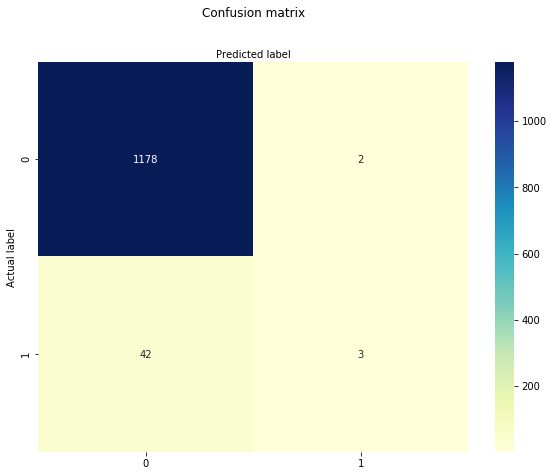

In [292]:
# Confusion matrix
plt.rcParams['figure.figsize'] = (8,6)

# Get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)

# Plot as heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), cmap="YlGnBu", annot=True,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

- Classifier predicts that all observations belong to the bad wine - class
- Within the testing set, there were 45 high quality wines, which were all predicted to be of low quality. 
- That is why accuracy is a horrible metric for performance evaluation in this case
- Accuracy and costs 
- TN, FN, FP, TP
- Discuss costs associated

##### Precision

In [293]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))


Accuracy: 0.9640816326530612
Precision: 0.6
Recall: 0.06666666666666667


#### AUC 

- AUC is an accepted traditional performance metric for a ROC Curve (SMOTE Paper),Duda, Hart, & Stork, 2001; Bradley, 1997; Lee, 2000)
- ROC Convex Hull?

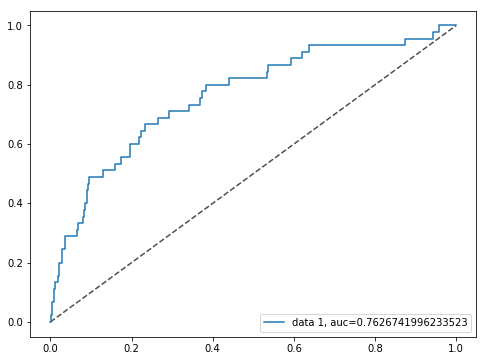

In [294]:
y_pred_proba = baseline_model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Random Oversampling

In [347]:
from imblearn import over_sampling 
ros = over_sampling.RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_resample(x, y)

# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
oversampled_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True, class_weight='balanced')

# Fit the model 
oversampled_model.fit(X_oversampled, y_oversampled );

##### NOW RE-WEIGHT THE LEARNED PROBABILITES!!! EXTREMLY IMPORTANT TO CHECK HERE #####

#### Prior correction

- Having used the oversampled sample, need to adjust prior probabilities. 
- Luckily, this only means adjusting the intercept

In [348]:
print('Un-corrected model intercept: ' + str(oversampled_model.intercept_))

# Get current intercept
current_intercept = oversampled_model.intercept_

# Get population values as simple sample averages from the training sample
tau = sum(y_train) / len(y_train)

# Resampled population values
y_hat = sum(y_oversampled) / len(y_oversampled)

# Rescale the intercept using the formula 
corrected_intercept = current_intercept - np.log(  ((1-tau) / tau) *  (y_hat / (1-y_hat)))

print('Corrected model intercept: ' + str(corrected_intercept))

# Set corrected intercept as new model intercept
oversampled_model.intercept_ = corrected_intercept

Un-corrected model intercept: [-6.13600769]
Corrected model intercept: [-9.40204978]


#### Simple Over / Undersampling using balancing

In [349]:
# Make predictions on testing values
y_pred_oversampled = oversampled_model.predict(x_test)

# Accuracy
accuracy = metrics.accuracy_score(y_test,y_pred_oversampled)
print(accuracy)

metrics.confusion_matrix(y_test,y_pred_oversampled)


0.963265306122449


array([[1180,    0],
       [  45,    0]])

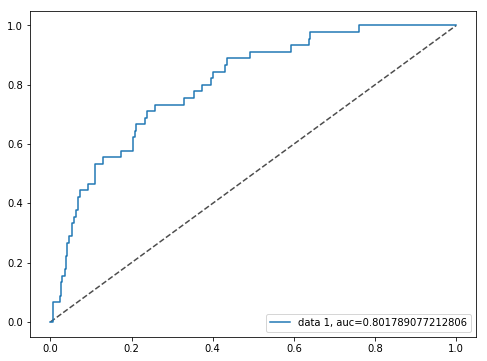

In [350]:
y_over_proba = oversampled_model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_over_proba)
auc = metrics.roc_auc_score(y_test, y_over_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Random Under-Sampling of the majority class

In [342]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_undersampled, y_undersampled = cc.fit_resample(x_train, y_train)

# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
undersampled_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True, class_weight='balanced')

# Fit the model 
undersampled_model.fit(X_undersampled, y_undersampled);

# Make predictions on testing values
y_pred_under = undersampled_model.predict(x_test)

# Accuracy
accuracy = metrics.accuracy_score(y_test,y_pred_under)
print(accuracy)

metrics.confusion_matrix(y_test,y_pred_under)


0.6628571428571428


array([[778, 402],
       [ 11,  34]])

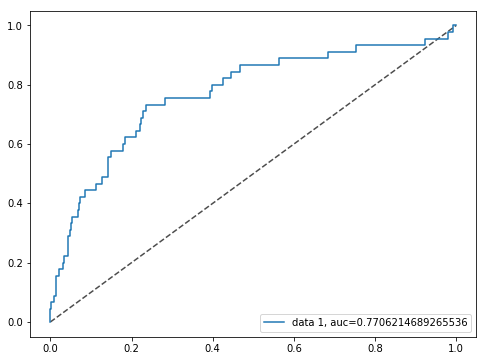

In [343]:
y_under_proba = undersampled_model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_under_proba)
auc = metrics.roc_auc_score(y_test, y_under_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### SMOTE Chawla et al (2002)

##### Abstract
- Approach for dealing with imbalanced datasets
- Imbalance: Not equal representation of classification categories
- Happens often in the real world
- Cost of misclassifying an "interesting" example are a lot higer than misclassifying "normal" examples
- Paper shows a combination of over-sampling the minority class and under-sampling the majority class
- This can achive better performance in ROC space than only under-sampling the majority class
- Method involves creating synthetic minority class examples

##### Introduction

- Imbalance of order 100 to 1 can be found in fraud detection 
- others report imbalances of up to 100.000 to 1 (Provost & Fawcett, 2001)
- Performance is often evaluated using predictive accuracy 
- Not appropriate when data is imbalanced and/or costs of different errors vary 
- Example: Cancer prediction / mammography 
- In the case of severe imbalance, a simple strategy of always predicting the majority class would give an almost perfect predicitve accuracy
- Simple predictive accuracy is not appropriate in such situations!
- AUC is an accepted tradional performance metric 
-  ROC Convex Hull -> Very interesting, check it out!

How has the machine learning community addressed the issue of class imbalance?
- Assign distinct costs to training examples
- Re-sample the original dataset
        - Either over sample the minority class
        - And / Or under-sample the majority class
    
Approach presented in the paper uses under-sampling of the majority class with a special form of over-sampling of the minority class

##### Performance Measures
- Performance is typically evaluated by a confusion matrix
- In the context of balanced datasets and equal error costs, it is reasonable to use error the error rate as a performance metric
$$ error = 1- Accuracy$$

- In presence of imbalanced datasets with unequal error costs, more appropriate to use the ROC curve
- ROC curves can be thought of as representing the family of best decision boundaries for relative costs of TP and FP
- X axis: % False positives
- Y axis: % True positives
- Ideal point on the ROC curve would be (0,100), all positive examples are classified correctly and no negative examples are misclassified as positive
- One way a ROC curve can be swept out is by manipulating the balance of training samples for each class in a training set

##### Previous Work: Imbalanced datasets 
- Kubat and Matwin (1997) selectively under-sample the majority class while keeping the original population of the minority class
- Minority examples were divided into four categories: Some noise overlapping the positive class descision regon, borderline samples, redundant samples and safe samples
- Ling and Li (1998): Combine over-sampling the minority class with under-sampling the majority class
- used lift analysis instead of accuracy
- lift curve is more similar to an ROC curve, but more tailored to marketing
- Solberg and Solberg (1996): Oil-slick classification, balance 50-50, achieved 14% error rate on the interesting samples and 4 % error on the "negative" samples
- Precision and recall

*Literature summary: Under-sampling the majority class enables better classifiers to be built than over-sampling the minority class!*
-> Very interesting summary, check?
- Combination of the two as done in previous work does not lead to classifiers that outperform those built with undersampling of majority
- Oversampling of the minority class has been donw by sampling with replacement from the original data, this might be an issue -> SMOTE

#### SMOTE

- Previous research discussed over-sampling with replacment and showed that it doesn't significantly improve minority class recognition
- Authors argue with underlying effect in terms of descision region feature space
- As the minority class is over-sampled by increasing amounts, the effect is to identify similar but more specific regions in the feature space as the descision region for the minority class

Understanding over- and undersampling in terms of descision regions
-> Descision boundary for linear regression?

- Propose an over-sampling approach in which the minority class is over-sampled by creating synthetic examples, rather than oversampling with replacement
- Inspired by handwriting recognition: Used real pictures and perturbed the data a bit to generate new samples
- Generate synthetic examples by operating in "feature space" not "data space"
- Taking each minority class sample, introducing synthetic examples along the line segments, joining any / all of the k-miniority class nearest neighbors
- Samples are generated by taking the difference between the feature vector (sample) under consideration and it's nearest neighbor.
- Multiply this difference by a random number between 0 and 1, add it to the feature vector under consideration
- Causes the selection of a random point along the line segment between two specific features
- Forces the decision region of the minority class to become more general
- The amount of over-sampling is a parameter of the system, series of ROC curves can be generated for different populations and ROC analysis performed

- Synthetic samples cause the classifier to create larger and less specific decision regions, rather than smaller and more specific regions
- Better for decision trees?

##### Under-sampling and SMOTE Combination
- Majority class under-sampled, by randomly removing samples until the minority class becomes some specififed percentage of the majority class
- Forces the learner to experience varying degrees of under-sampling
- By applying a combination of under-sampling and over-sampling, the inital bias of the learner is reversed in favor of the minority class
- This is a crucial but somewhat overlooked part of the paper! 
- The best performance is reached when combining SMOTE and under-sampling of the majority class

> Combination of SMOTE and under-sampling is the way to go according to the authors

In [385]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(k_neighbors= 2, sampling_strategy= 0.5)

# Use smote to resample
x_smote, y_smote = smote.fit_resample(x_train,y_train)
print(len(x_smote))
print(sum(y_smote))

5307
1769


In [386]:
smote_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True)

# Fit on oversampled data set
smote_model.fit(x_smote,y_smote)

#### Make Prior correction ###
# Get current intercept
smote_intercept = smote_model.intercept_

print('Corrected model intercept: ' + str(smote_intercept))


# Get population values as simple sample averages from the training sample
tau = sum(y_train) / len(y_train)

# Resampled population values
y_hat_smote = sum(y_smote) / len(y_smote)

# Rescale the intercept using the formula 
smote_corrected_intercept = current_intercept - np.log(  ((1-tau) / tau) *  (y_hat_smote / (1-y_hat_smote)))

print('Corrected model intercept: ' + str(corrected_intercept))

# Set corrected intercept as new model intercept
smote_model.intercept_ = smote_corrected_intercept

Corrected model intercept: [-5.07816638]
Corrected model intercept: [-9.40204978]


In [387]:
y_smote_proba = smote_model.predict_proba(x_test)
y_smote_proba[::,1]

array([0.04562935, 0.00372817, 0.00362067, ..., 0.00182705, 0.00465887,
       0.01240275])

In [390]:
y_smote_proba = smote_model.predict_proba(x)[::,1]


y_pred_smote = [1 if prob >= 0.01 else 0 for prob in y_smote_proba]

#y_pred_smote = smote_model.predict(x)

# Accuracy
accuracy = metrics.accuracy_score(y,y_pred_smote)
print(accuracy)
metrics.confusion_matrix(y,y_pred_smote)


0.6284197631686402


array([[2939, 1779],
       [  41,  139]])

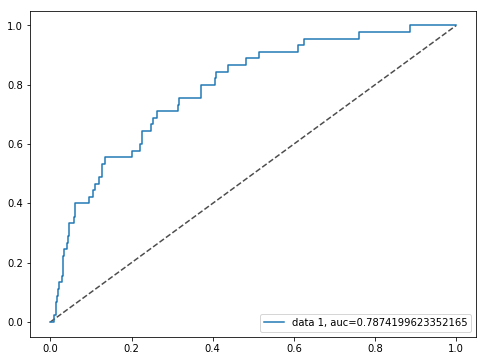

In [391]:
y_smote_proba = smote_model.predict_proba(x_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_smote_proba)
auc = metrics.roc_auc_score(y_test, y_smote_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### SMOTE with random under-sampling

In [368]:
# Under sample the data generated from smote using random under-sampling 
len(x_smote)

len(x_train)

3673

In [355]:
sum(y_smote_ru) / len(y_smote_ru)

0.42857142857142855

In [357]:
smote_ru_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True)

# Fit on oversampled data set
smote_ru_model.fit(x_smote_ru,y_smote_ru)

## Correct intercept

# Get current intercept
smote_ru_intercept = smote_ru_model.intercept_

print('Un-corrected model intercept: ' + str(smote_ru_intercept))


# Get population values as simple sample averages from the training sample
tau = sum(y_train) / len(y_train)

# Resampled population values
y_hat_smote_ru = sum(y_smote_ru) / len(y_smote_ru)

# Rescale the intercept using the formula 
smote_ru_corrected_intercept = current_intercept - np.log(  ((1-tau) / tau) *  (y_hat_smote_ru / (1-y_hat_smote_ru)))

print('Corrected model intercept: ' + str(smote_ru_corrected_intercept))

# Set corrected intercept as new model intercept
smote_model.intercept_ = smote_ru_corrected_intercept

Un-corrected model intercept: [-0.9867203]
Corrected model intercept: [-9.11436771]


In [358]:
smote_ru_proba

array([[0.15336636, 0.84663364],
       [0.59164782, 0.40835218],
       [0.69497418, 0.30502582],
       ...,
       [0.8676462 , 0.1323538 ],
       [0.53882171, 0.46117829],
       [0.27862901, 0.72137099]])

In [359]:
# Make predictions on testing values
smote_ru_proba = smote_ru_model.predict_proba(x_test)

y_pred_smote_ru = [1 if prob >= 0.5 else 0 for prob in smote_ru_proba[::,1]]

# Accuracy
accuracy = metrics.accuracy_score(y_test,y_pred_smote_ru)
print(accuracy)
metrics.confusion_matrix(y_test,y_pred_smote_ru)


0.726530612244898


array([[857, 323],
       [ 12,  33]])

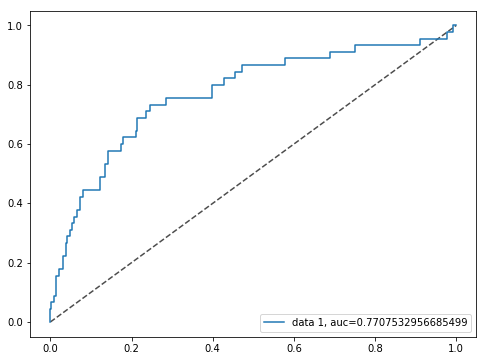

In [360]:
smote_ru_proba = smote_ru_model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  smote_ru_proba)
auc = metrics.roc_auc_score(y_test, smote_ru_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### XGBoost Baseline - Doesn't help much in this case!
- Shows that this is not only an issue for logistic regression
- I think the dataset is actually not informative at all

In [268]:
from xgboost import XGBClassifier
from xgboost import plot_tree, to_graphviz

In [271]:
# fit model on training data
boost = XGBClassifier()

# Evaluation set
eval_set = [(x_train, y_train)]

# Fit the model
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
metrics.accuracy_score(y_test, predictions)


0.9640816326530612

In [273]:
# make predictions for test data
#y_pred = modelx.predict(x_test)
y_pred = model.predict(x_test)

In [274]:
metrics.confusion_matrix(y_test,y_pred)

array([[1178,    2],
       [  42,    3]])

#### References 

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.
  
He, H., & Ma, Y. (Eds.). (2013). Imbalanced learning: foundations, algorithms, and applications. John Wiley & Sons.

G. Weiss (2013). Foundations of Imbalanced Learning, in Imbalanced learning: foundations, algorithms, and applications. edited by He, H., & Ma, Y.
 